# Eliminación de sobreajuste

Se utilizará la base de datos de perros y gatos.

In [2]:
## Primeramente se descarga la base de datos que será la de perros y gatos
import cv2
import numpy as np
import os
import zipfile
from matplotlib import image

files=zipfile.ZipFile('cats_and_dogs_small.zip','r')
files.extractall('')

x_dog=[]
x_cat=[]


In [3]:
from PIL import Image
x_size=32
y_size=32

for name in files.namelist():
    if '/dogs/' in name and '.jpg' in name:
        a=cv2.imread(name)
        a=cv2.resize(a,(x_size,y_size)) # Dimensión de la imagen
        img = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
        #img2=img.resize(200,200) # Mobilenet (224,224,3)
        x_dog.append(img)
        
    elif '/cats/' in name and '.jpg' in name:
        a=cv2.imread(name)
        a=cv2.resize(a,(x_size,y_size)) # Dimensión de la imagen
        img = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
        x_cat.append(img)
print(len(x_dog),len(x_cat))
x_dog=np.stack(x_dog,axis=0)
x_cat=np.stack(x_cat,axis=0)

2000 2000


## Normalización y One Hot

In [4]:
print(type(x_dog),x_dog.shape)
print(type(x_cat),x_cat.shape)
print('Valores minimos y maximos sin normalizar')
print(x_dog.min(),x_dog.max())
print(x_cat.min(),x_cat.max())
x_dog=x_dog.astype('float32')
x,y,z,w=x_dog.shape
y_dog=np.zeros((x,1),dtype=int)
x_cat=x_cat.astype('float32')
x,y,z,w=x_cat.shape
y_cat=np.ones((x,1),dtype=int)
x_dog/=255#(x_dog/127.5)-1#x_dog/=255
x_cat/=255#(x_cat/127.5)-1#x_cat/=255
## Conjunto combinado de perros y gatos
x_comb=np.vstack((x_dog,x_cat))
y_comb=np.vstack((y_dog,y_cat))
print(x_comb.ndim,x_comb.shape)
print('Valores minimos y maximos normalizados')
print(x_comb.min(),x_comb.max())
#print(y_dog)


### ONE HOT
from keras.utils import to_categorical
y_dog_oh=to_categorical(y_dog,y_dog.max()+2)
y_cat_oh=to_categorical(y_cat,y_cat.max()+1)
print(y_comb[3455])
y_comb_oh=to_categorical(y_comb,y_comb.max()+1)
print(y_comb_oh[3455])
print(type(y_comb_oh),y_comb_oh.shape)
#print(y_cat_oh.shape)
#print(y_dog_oh.shape)
#print(y_dog_oh)
#print(y_cat_oh)

<class 'numpy.ndarray'> (2000, 32, 32, 3)
<class 'numpy.ndarray'> (2000, 32, 32, 3)
Valores minimos y maximos sin normalizar
0 255
0 255
4 (4000, 32, 32, 3)
Valores minimos y maximos normalizados
0.0 1.0
[1]
[0. 1.]
<class 'numpy.ndarray'> (4000, 2)


## Division de datos 60 20 20

In [5]:
xx,yy,ww,zz=x_cat.shape

x_train=np.vstack((x_cat[:int(xx*0.6),:,:,1:2],x_dog[:int(xx*0.6),:,:,1:2]))
y_train=np.vstack((y_cat_oh[:int(xx*0.6),:],y_dog_oh[:int(xx*0.6),:]))
x_val=np.vstack((x_cat[int(xx*0.6):int(xx*0.8),:,:,1:2],x_dog[int(xx*0.6):int(xx*0.8),:,:,1:2]))
y_val=np.vstack((y_cat_oh[int(xx*0.6):int(xx*0.8),:],y_dog_oh[int(xx*0.6):int(xx*0.8),:]))
x_test=np.vstack((x_cat[int(xx*0.8):,:,:,1:2],x_dog[int(xx*0.8):,:,:,1:2]))
y_test=np.vstack((y_cat_oh[int(xx*0.8):,:],y_dog_oh[int(xx*0.8):,:]))

print(x_test.min(),x_test.max())

0.0 1.0


## Red LeNet-5

In [5]:
import tensorflow as tf
from keras.models import Model, load_model
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint =  ModelCheckpoint('vgg16_finetune.h5', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)
earlystopper = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) 

#"""

#"""

model=Sequential()
model.add(tf.keras.layers.Conv2D(6,(5,5),input_shape=(x_size,y_size,1),activation='tanh',padding='valid',strides=1)) #C1

model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2))) #S2

model.add(tf.keras.layers.Conv2D(16,(5,5),activation='tanh',padding='valid',strides=1)) #c3

model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2))) #s4
model.add(tf.keras.layers.Flatten())

model.add(Dense(120,activation='tanh')) #c5
model.add(Dense(84,activation='tanh')) #c6

from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff,2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)
    
model.add(RBFLayer(2,0.5)) #c7

model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=0.25),metrics=['accuracy'])
hist_1=model.fit(x_train,y_train,verbose=1, batch_size=64,epochs=80,validation_data=(x_val,y_val))

Epoch 1/80
38/38 [==============================] - 3s 71ms/step - loss: 0.6930 - accuracy: 0.5063 - val_loss: 0.6925 - val_accuracy: 0.5150
Epoch 2/80
38/38 [==============================] - 2s 58ms/step - loss: 0.6916 - accuracy: 0.5367 - val_loss: 0.6893 - val_accuracy: 0.5437
Epoch 3/80
38/38 [==============================] - 2s 60ms/step - loss: 0.6883 - accuracy: 0.5542 - val_loss: 0.6863 - val_accuracy: 0.5638
Epoch 4/80
38/38 [==============================] - 2s 53ms/step - loss: 0.6834 - accuracy: 0.5646 - val_loss: 0.6921 - val_accuracy: 0.5175
Epoch 5/80
38/38 [==============================] - 2s 55ms/step - loss: 0.6818 - accuracy: 0.5537 - val_loss: 0.6846 - val_accuracy: 0.5425
Epoch 6/80
38/38 [==============================] - 2s 55ms/step - loss: 0.6776 - accuracy: 0.5750 - val_loss: 0.6920 - val_accuracy: 0.5288
Epoch 7/80
38/38 [==============================] - 2s 55ms/step - loss: 0.6760 - accuracy: 0.5858 - val_loss: 0.6864 - val_accuracy: 0.5537
Epoch 8/80
38

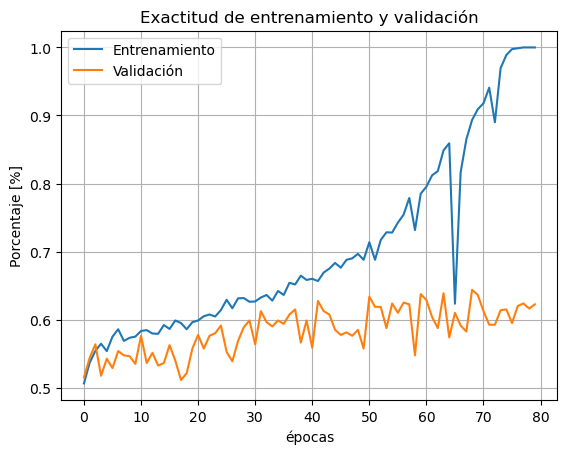

In [6]:
type(hist_1.history['loss'])
import matplotlib.pyplot as plt
plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])
plt.title('Exactitud de entrenamiento y validación')
plt.xlabel('épocas')
plt.ylabel('Porcentaje [%]')
plt.legend(['Entrenamiento','Validación'])
plt.grid()

## Test de al red LeNet5 v1

In [7]:
pred=model.predict(x_test)
pred=np.argmax(pred,axis=1)
y1=np.argmax(y_test,axis=1)

#label=np.argmax(yp_oh)
exactitud_test=0
for a in range(len(pred)):
    if pred[a]==y1[a]:
        exactitud_test+=1
print('exactitud de la prueba= ',100*exactitud_test/len(pred),'%')

25/25 [==============================] - 0s 2ms/step
exactitud de la prueba=  59.625 %


# 1) Red LeNet5 con regularización mediante L1oL2

l1 o l2

In [8]:
import tensorflow as tf
from keras.models import Model, load_model
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint =  ModelCheckpoint('vgg16_finetune.h5', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)
earlystopper = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) 

#"""

#"""
k_r=tf.keras.regularizers.L1L2(l1=1e-5,l2=1e-4)
b_r=tf.keras.regularizers.L2(l2=1e-4)
a_r=tf.keras.regularizers.L2(l2=1e-5)
model=Sequential()
model.add(tf.keras.layers.Conv2D(6,(5,5),input_shape=(x_size,y_size,1),activation='tanh',padding='valid',strides=1)) #C1

model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2))) #S2

model.add(tf.keras.layers.Conv2D(16,(5,5),activation='tanh',padding='valid',strides=1)) #c3

model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2))) #s4
model.add(tf.keras.layers.Flatten())

model.add(Dense(120,activation='tanh',kernel_regularizer=k_r,bias_regularizer=b_r,activity_regularizer=a_r)) #c5
model.add(Dense(84,activation='tanh',kernel_regularizer=k_r,bias_regularizer=b_r,activity_regularizer=a_r)) #c6

from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff,2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)
    
model.add(RBFLayer(2,0.5)) #c7

model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=0.23),metrics=['accuracy'])
hist_2=model.fit(x_train,y_train,verbose=1, batch_size=64,epochs=120,validation_data=(x_val,y_val))

Epoch 1/120
38/38 [==============================] - 3s 71ms/step - loss: 0.7564 - accuracy: 0.5088 - val_loss: 0.7535 - val_accuracy: 0.5063
Epoch 2/120
38/38 [==============================] - 2s 55ms/step - loss: 0.7526 - accuracy: 0.5371 - val_loss: 0.7547 - val_accuracy: 0.5138
Epoch 3/120
38/38 [==============================] - 2s 52ms/step - loss: 0.7499 - accuracy: 0.5437 - val_loss: 0.7486 - val_accuracy: 0.5400
Epoch 4/120
38/38 [==============================] - 2s 57ms/step - loss: 0.7467 - accuracy: 0.5512 - val_loss: 0.7482 - val_accuracy: 0.5450
Epoch 5/120
38/38 [==============================] - 2s 55ms/step - loss: 0.7428 - accuracy: 0.5592 - val_loss: 0.7492 - val_accuracy: 0.5550
Epoch 6/120
38/38 [==============================] - 2s 54ms/step - loss: 0.7429 - accuracy: 0.5663 - val_loss: 0.7493 - val_accuracy: 0.5537
Epoch 7/120
38/38 [==============================] - 2s 52ms/step - loss: 0.7404 - accuracy: 0.5654 - val_loss: 0.7511 - val_accuracy: 0.5213
Epoch 

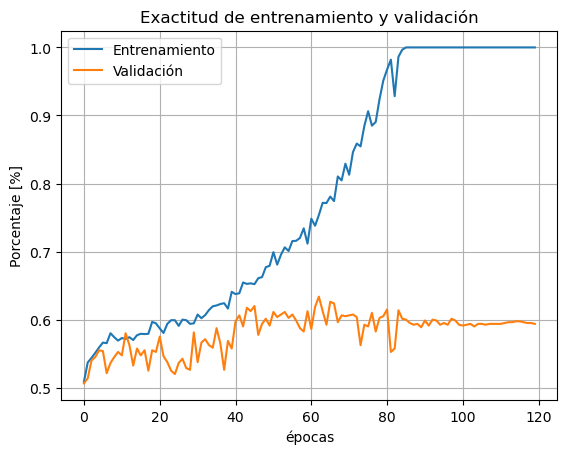

In [9]:
type(hist_2.history['loss'])
import matplotlib.pyplot as plt
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.title('Exactitud de entrenamiento y validación')
plt.xlabel('épocas')
plt.ylabel('Porcentaje [%]')
plt.legend(['Entrenamiento','Validación'])
plt.grid()

In [10]:
pred=model.predict(x_test)
pred=np.argmax(pred,axis=1)
y1=np.argmax(y_test,axis=1)

#label=np.argmax(yp_oh)
exactitud_test=0
for a in range(len(pred)):
    if pred[a]==y1[a]:
        exactitud_test+=1
print('exactitud de la prueba= ',100*exactitud_test/len(pred),'%')

25/25 [==============================] - 0s 1ms/step
exactitud de la prueba=  58.75 %


# 2) Regularización con Dropout

Uso de Dropout para capas flatten y convolucionales.


In [11]:
import tensorflow as tf
from keras.models import Model, load_model
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint =  ModelCheckpoint('vgg16_finetune.h5', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)
earlystopper = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) 

#"""

#"""

model=Sequential()
model.add(tf.keras.layers.Conv2D(6,(5,5),input_shape=(x_size,y_size,1),activation='tanh',padding='valid',strides=1)) #C1

model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2))) #S2

model.add(tf.keras.layers.Conv2D(16,(5,5),activation='tanh',padding='valid',strides=1)) #c3
model.add(Dropout(0.3))
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2))) #s4
model.add(tf.keras.layers.Flatten())

model.add(Dense(120,activation='tanh')) #c5
model.add(Dropout(0.5))
model.add(Dense(84,activation='tanh')) #c6
model.add(Dropout(0.6))
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff,2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)
    
model.add(RBFLayer(2,0.5)) #c7

model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=0.25),metrics=['accuracy'])
hist_3=model.fit(x_train,y_train,verbose=1, batch_size=64,epochs=120,validation_data=(x_val,y_val))

Epoch 1/120
38/38 [==============================] - 3s 62ms/step - loss: 0.6964 - accuracy: 0.4971 - val_loss: 0.6926 - val_accuracy: 0.5013
Epoch 2/120
38/38 [==============================] - 2s 45ms/step - loss: 0.6958 - accuracy: 0.5108 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/120
38/38 [==============================] - 2s 46ms/step - loss: 0.6924 - accuracy: 0.5188 - val_loss: 0.6958 - val_accuracy: 0.5050
Epoch 4/120
38/38 [==============================] - 2s 44ms/step - loss: 0.6923 - accuracy: 0.5179 - val_loss: 0.6889 - val_accuracy: 0.5638
Epoch 5/120
38/38 [==============================] - 2s 48ms/step - loss: 0.6921 - accuracy: 0.5396 - val_loss: 0.6957 - val_accuracy: 0.4950
Epoch 6/120
38/38 [==============================] - 2s 46ms/step - loss: 0.6904 - accuracy: 0.5350 - val_loss: 0.6921 - val_accuracy: 0.5238
Epoch 7/120
38/38 [==============================] - 2s 48ms/step - loss: 0.6881 - accuracy: 0.5471 - val_loss: 0.6917 - val_accuracy: 0.5188
Epoch 

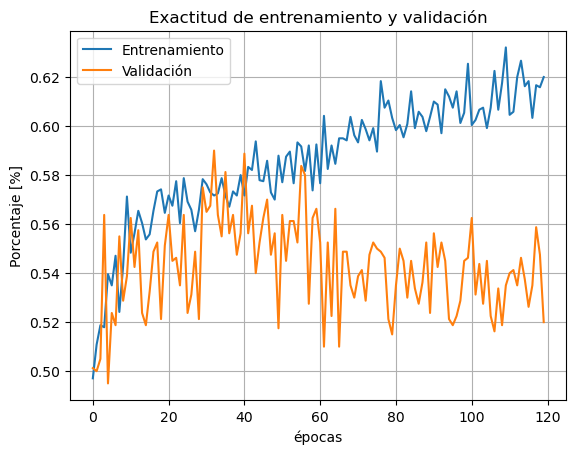

In [12]:
type(hist_3.history['loss'])
import matplotlib.pyplot as plt
plt.plot(hist_3.history['accuracy'])
plt.plot(hist_3.history['val_accuracy'])
plt.title('Exactitud de entrenamiento y validación')
plt.xlabel('épocas')
plt.ylabel('Porcentaje [%]')
plt.legend(['Entrenamiento','Validación'])
plt.grid()

In [13]:
pred=model.predict(x_test)
pred=np.argmax(pred,axis=1)
y1=np.argmax(y_test,axis=1)

#label=np.argmax(yp_oh)
exactitud_test=0
for a in range(len(pred)):
    if pred[a]==y1[a]:
        exactitud_test+=1
print('exactitud de la prueba= ',100*exactitud_test/len(pred),'%')

25/25 [==============================] - 0s 1ms/step
exactitud de la prueba=  52.875 %


# 3) Regularización por BatchNormalization

In [14]:
import tensorflow as tf
from keras.models import Model, load_model
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint =  ModelCheckpoint('vgg16_finetune.h5', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)
earlystopper = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) 

#"""

#"""

model=Sequential()
model.add(tf.keras.layers.Conv2D(6,(5,5),input_shape=(x_size,y_size,1),activation='tanh',padding='valid',strides=1)) #C1
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2))) #S2

model.add(tf.keras.layers.Conv2D(16,(5,5),activation='tanh',padding='valid',strides=1)) #c3
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2))) #s4
model.add(tf.keras.layers.Flatten())

model.add(Dense(120,activation='tanh')) #c5
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(84,activation='tanh')) #c6

from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff,2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)
    
model.add(RBFLayer(2,0.5)) #c7

model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=0.25),metrics=['accuracy'])
hist_4=model.fit(x_train,y_train,verbose=1, batch_size=64,epochs=80,validation_data=(x_val,y_val))

Epoch 1/80
38/38 [==============================] - 3s 56ms/step - loss: 0.7120 - accuracy: 0.5288 - val_loss: 0.7166 - val_accuracy: 0.5000
Epoch 2/80
38/38 [==============================] - 2s 46ms/step - loss: 0.6915 - accuracy: 0.5683 - val_loss: 0.7424 - val_accuracy: 0.5000
Epoch 3/80
38/38 [==============================] - 2s 51ms/step - loss: 0.6843 - accuracy: 0.5708 - val_loss: 0.7696 - val_accuracy: 0.5000
Epoch 4/80
38/38 [==============================] - 2s 55ms/step - loss: 0.6689 - accuracy: 0.5917 - val_loss: 0.6992 - val_accuracy: 0.5437
Epoch 5/80
38/38 [==============================] - 2s 58ms/step - loss: 0.6481 - accuracy: 0.6342 - val_loss: 0.7333 - val_accuracy: 0.5400
Epoch 6/80
38/38 [==============================] - 2s 49ms/step - loss: 0.6561 - accuracy: 0.6283 - val_loss: 0.7636 - val_accuracy: 0.5437
Epoch 7/80
38/38 [==============================] - 2s 61ms/step - loss: 0.6156 - accuracy: 0.6708 - val_loss: 0.8907 - val_accuracy: 0.5350
Epoch 8/80
38

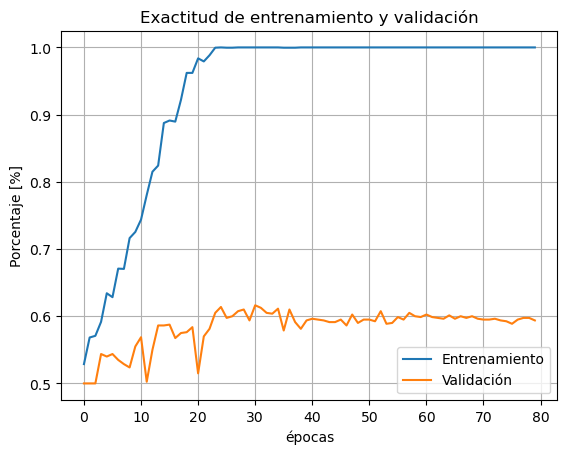

In [15]:
type(hist_4.history['loss'])
import matplotlib.pyplot as plt
plt.plot(hist_4.history['accuracy'])
plt.plot(hist_4.history['val_accuracy'])
plt.title('Exactitud de entrenamiento y validación')
plt.xlabel('épocas')
plt.ylabel('Porcentaje [%]')
plt.legend(['Entrenamiento','Validación'])
plt.grid()

In [16]:
pred=model.predict(x_test)
pred=np.argmax(pred,axis=1)
y1=np.argmax(y_test,axis=1)

#label=np.argmax(yp_oh)
exactitud_test=0
for a in range(len(pred)):
    if pred[a]==y1[a]:
        exactitud_test+=1
print('exactitud de la prueba= ',100*exactitud_test/len(pred),'%')

25/25 [==============================] - 0s 2ms/step
exactitud de la prueba=  59.625 %


# 4) Regularización por data augmentation

In [17]:
import tensorflow as tf
from keras.models import Model, load_model
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
checkpoint =  ModelCheckpoint('vgg16_finetune.h5', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)
earlystopper = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) 

#"""

#"""
## Uso de RandomCrop
#tf.keras.layers.experimental.preprocessing.RandomCrop()
#tf.keras.layers.CenterCrop(x_size,y_size,1)
tf.keras.layers.RandomCrop(x_size,y_size,1)

model=Sequential()
model.add(tf.keras.layers.Conv2D(6,(5,5),input_shape=(x_size,y_size,1),activation='tanh',padding='valid',strides=1)) #C1

model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2))) #S2

model.add(tf.keras.layers.Conv2D(16,(5,5),activation='tanh',padding='valid',strides=1)) #c3

model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2))) #s4
model.add(tf.keras.layers.Flatten())

model.add(Dense(120,activation='tanh')) #c5
model.add(Dense(84,activation='tanh')) #c6

from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff,2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)
    
model.add(RBFLayer(2,0.5)) #c7

model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=0.25),metrics=['accuracy'])
hist_5=model.fit(x_train,y_train,verbose=1, batch_size=64,epochs=80,validation_data=(x_val,y_val))

Epoch 1/80
38/38 [==============================] - 3s 62ms/step - loss: 0.6938 - accuracy: 0.5096 - val_loss: 0.6918 - val_accuracy: 0.5350
Epoch 2/80
38/38 [==============================] - 2s 53ms/step - loss: 0.6907 - accuracy: 0.5412 - val_loss: 0.6905 - val_accuracy: 0.5163
Epoch 3/80
38/38 [==============================] - 2s 57ms/step - loss: 0.6881 - accuracy: 0.5446 - val_loss: 0.6869 - val_accuracy: 0.5600
Epoch 4/80
38/38 [==============================] - 2s 56ms/step - loss: 0.6845 - accuracy: 0.5542 - val_loss: 0.6850 - val_accuracy: 0.5450
Epoch 5/80
38/38 [==============================] - 2s 51ms/step - loss: 0.6821 - accuracy: 0.5546 - val_loss: 0.6993 - val_accuracy: 0.5437
Epoch 6/80
38/38 [==============================] - 2s 56ms/step - loss: 0.6806 - accuracy: 0.5675 - val_loss: 0.6945 - val_accuracy: 0.5425
Epoch 7/80
38/38 [==============================] - 2s 54ms/step - loss: 0.6804 - accuracy: 0.5571 - val_loss: 0.6897 - val_accuracy: 0.5300
Epoch 8/80
38

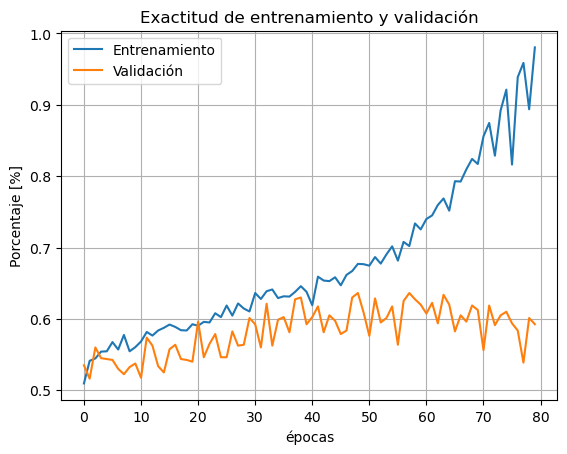

In [18]:
type(hist_5.history['loss'])
import matplotlib.pyplot as plt
plt.plot(hist_5.history['accuracy'])
plt.plot(hist_5.history['val_accuracy'])
plt.title('Exactitud de entrenamiento y validación')
plt.xlabel('épocas')
plt.ylabel('Porcentaje [%]')
plt.legend(['Entrenamiento','Validación'])
plt.grid()

In [19]:
pred=model.predict(x_test)
pred=np.argmax(pred,axis=1)
y1=np.argmax(y_test,axis=1)

#label=np.argmax(yp_oh)
exactitud_test=0
for a in range(len(pred)):
    if pred[a]==y1[a]:
        exactitud_test+=1
print('exactitud de la prueba= ',100*exactitud_test/len(pred),'%')

25/25 [==============================] - 0s 1ms/step
exactitud de la prueba=  58.75 %


# 5) Regularización con todos los métodos

> - **L1 o norma L1 Lasso**

> - **Dropout**

> - **Normalización por lotes (BatchNormalization)**

> - **Aumento de los datos (Data augmentation)**


<div class="alert alert-block alert-info">
<b>Extra:</b> También se usarán los <b>Callbacks</b> de <i>reducción de factor de aprendizaje</i> y el "<i>EarlyStopper</i>".
</div>



In [14]:
import tensorflow as tf
from keras.models import Model, load_model
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=8, verbose=1, mode='max', min_lr=5e-5)
#checkpoint =  ModelCheckpoint('vgg16_finetune.h5', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)
earlystopper = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True) 
## L1oL2
k_r=tf.keras.regularizers.L1L2(l1=1e-5,l2=1e-4)
b_r=tf.keras.regularizers.L2(l2=1e-4)
a_r=tf.keras.regularizers.L2(l2=1e-5)
#"""

#"""
# Data Augmentation con RandomCrop
tf.keras.layers.RandomCrop(x_size,y_size,1)

model=Sequential()
model.add(tf.keras.layers.Conv2D(6,(5,5),input_shape=(x_size,y_size,1),activation='tanh',padding='valid',strides=1)) #C1
model.add(Dropout(0.2)) #Dropout
model.add(tf.keras.layers.BatchNormalization()) # BatchNormalization
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2))) #S2
model.add(Dropout(0.9)) #Dropout
model.add(tf.keras.layers.BatchNormalization()) # BatchNormalization
model.add(tf.keras.layers.Conv2D(16,(5,5),activation='tanh',padding='valid',strides=1)) #c3
model.add(Dropout(0.6)) #Dropout
model.add(tf.keras.layers.BatchNormalization()) # BatchNormalization
model.add(tf.keras.layers.AveragePooling2D(pool_size=(2,2))) #s4
model.add(Dropout(0.5)) #Dropout
model.add(tf.keras.layers.BatchNormalization()) # BatchNormalization
model.add(tf.keras.layers.Flatten())

model.add(Dense(120,activation='tanh',kernel_regularizer=k_r,bias_regularizer=b_r,activity_regularizer=a_r)) #c5
model.add(Dropout(0.6)) #Dropout
model.add(tf.keras.layers.BatchNormalization()) # BatchNormalization
model.add(Dense(84,activation='tanh',kernel_regularizer=k_r,bias_regularizer=b_r,activity_regularizer=a_r)) #c6
model.add(Dropout(0.7)) #Dropout
model.add(tf.keras.layers.BatchNormalization()) # BatchNormalization

from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff,2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)
    
model.add(RBFLayer(2,0.5)) #c7

model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.25),metrics=['accuracy'])
hist_final=model.fit(x_train,y_train,verbose=1, batch_size=32,epochs=150,validation_data=(x_val,y_val),callbacks=[lr_reduce,earlystopper])

Epoch 1/150
75/75 [==============================] - 6s 53ms/step - loss: 8.4081 - accuracy: 0.5013 - val_loss: 6.2067 - val_accuracy: 0.5000 - lr: 0.2500
Epoch 2/150
75/75 [==============================] - 3s 42ms/step - loss: 3.9898 - accuracy: 0.5096 - val_loss: 2.6703 - val_accuracy: 0.5000 - lr: 0.2500
Epoch 3/150
75/75 [==============================] - 2s 23ms/step - loss: 2.2438 - accuracy: 0.5029 - val_loss: 1.5981 - val_accuracy: 0.5000 - lr: 0.2500
Epoch 4/150
75/75 [==============================] - 3s 37ms/step - loss: 1.8145 - accuracy: 0.5221 - val_loss: 1.3449 - val_accuracy: 0.5000 - lr: 0.2500
Epoch 5/150
75/75 [==============================] - 3s 36ms/step - loss: 1.5869 - accuracy: 0.5075 - val_loss: 1.1648 - val_accuracy: 0.5000 - lr: 0.2500
Epoch 6/150
75/75 [==============================] - 3s 38ms/step - loss: 1.3273 - accuracy: 0.4808 - val_loss: 1.2436 - val_accuracy: 0.5000 - lr: 0.2500
Epoch 7/150
75/75 [==============================] - 4s 48ms/step - lo

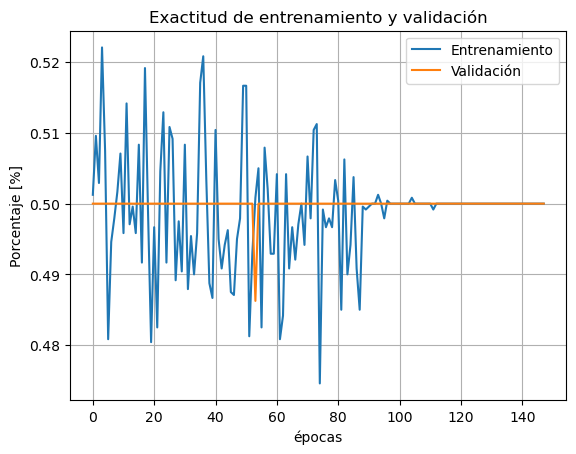

In [15]:
type(hist_final.history['loss'])
import matplotlib.pyplot as plt
plt.plot(hist_final.history['accuracy'])
plt.plot(hist_final.history['val_accuracy'])
plt.title('Exactitud de entrenamiento y validación')
plt.xlabel('épocas')
plt.ylabel('Porcentaje [%]')
plt.legend(['Entrenamiento','Validación'])
plt.grid()

In [16]:
pred=model.predict(x_test)
pred=np.argmax(pred,axis=1)
y1=np.argmax(y_test,axis=1)

#label=np.argmax(yp_oh)
exactitud_test=0
for a in range(len(pred)):
    if pred[a]==y1[a]:
        exactitud_test+=1
print('exactitud de la prueba= ',100*exactitud_test/len(pred),'%')

25/25 [==============================] - 0s 1ms/step
exactitud de la prueba=  50.0 %
